# testing out YTTiledArbitraryGrid

dev yt branch at https://github.com/chrishavlin/yt/tree/tiled_arbitrary_grid

WARNING: the nested grids can cache field data... initial implementaiton avoids this but doesnt account for field aliases. e.g., `('enzo','Density')` will **not** be cached but `

In [6]:
import yt 
from yt.data_objects.construction_data_containers import YTTiledArbitraryGrid
import matplotlib.pyplot as plt 
import numpy as np


ds = yt.load_sample("DeeplyNestedZoom")
# INTERESTING: NEED TO BUILD INDEX BEFORE DASK CALL OR YOU GET ERROR ON DASK COMPUTE
ds.index 
tag = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (64,64,64), # global dimension
                     2, # nchunks = nprocs
                     ds=ds)


yt : [INFO     ] 2024-06-10 15:55:18,038 Sample dataset found in '/home/chavlin/hdd/data/yt_data/yt_sample_sets/DeeplyNestedZoom/DD0025/data0025'
yt : [INFO     ] 2024-06-10 15:55:18,122 Parameters: current_time              = 14.1336338797
yt : [INFO     ] 2024-06-10 15:55:18,123 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-06-10 15:55:18,123 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-06-10 15:55:18,125 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-06-10 15:55:18,125 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-06-10 15:55:18,125 Parameters: current_redshift          = 14.092558914923
yt : [INFO     ] 2024-06-10 15:55:18,126 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2024-06-10 15:55:18,126 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2024-06-10 15:55:18,126 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-06-10 15:55:18,12

In [7]:
len(tag._grids)

2

In [8]:
vals = tag.to_numpy(('enzo','Density'))
vals.shape

(64, 64, 64)

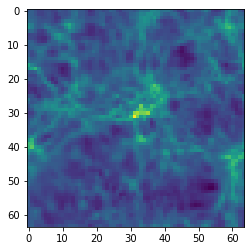

In [9]:
plt.imshow(np.log10(vals[:,:,32]))

In [1]:
from dask.distributed import Client
import yt 
from yt.data_objects.construction_data_containers import YTTiledArbitraryGrid
import matplotlib.pyplot as plt 
import numpy as np

In [2]:
c = Client(n_workers=5, processes=False, threads_per_worker=1)

In [3]:
c

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.68.117:8787/status,
Dashboard: http://192.168.68.117:8787/status,Workers: 5
Total threads: 5,Total memory: 31.18 GiB
Status: running,Using processes: False
Comm: inproc://192.168.68.117/18780/1,Workers: 5
Dashboard: http://192.168.68.117:8787/status,Total threads: 5
Started: Just now,Total memory: 31.18 GiB
Comm: inproc://192.168.68.117/18780/4,Total threads: 1
Dashboard: http://192.168.68.117:44539/status,Memory: 6.24 GiB
Nanny: None,


In [10]:
ds = yt.load_sample("DeeplyNestedZoom")
# INTERESTING: NEED TO BUILD INDEX BEFORE DASK CALL OR YOU GET ERROR ON DASK COMPUTE
ds.index 
tag = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (1024,1024,1024), # global dimension
                     256, # nchunks = nprocs
                     ds=ds)

print("build delayed array")
da = tag.to_dask(('enzo','Density'))
da

yt : [INFO     ] 2024-06-10 15:55:24,996 Sample dataset found in '/home/chavlin/hdd/data/yt_data/yt_sample_sets/DeeplyNestedZoom/DD0025/data0025'
yt : [INFO     ] 2024-06-10 15:55:25,073 Parameters: current_time              = 14.1336338797
yt : [INFO     ] 2024-06-10 15:55:25,074 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-06-10 15:55:25,074 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-06-10 15:55:25,075 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-06-10 15:55:25,075 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-06-10 15:55:25,075 Parameters: current_redshift          = 14.092558914923
yt : [INFO     ] 2024-06-10 15:55:25,076 Parameters: omega_lambda              = 0.6911
yt : [INFO     ] 2024-06-10 15:55:25,076 Parameters: omega_matter              = 0.3089
yt : [INFO     ] 2024-06-10 15:55:25,076 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-06-10 15:55:25,07

build delayed array


dask.array<setitem, shape=(1024, 1024, 1024), dtype=float64, chunksize=(256, 128, 128), chunktype=numpy.ndarray>

In [11]:
da.chunks

((256, 256, 256, 256),
 (128, 128, 128, 128, 128, 128, 128, 128),
 (128, 128, 128, 128, 128, 128, 128, 128))

In [12]:
yt.set_log_level(50)

In [13]:
%%time
da = tag.to_dask(('enzo','Density'))
plt.imshow(np.log10(da[:,:,1024].compute()))

IndexError: Index 1024 is out of bounds for axis 2 with size 1024

In [23]:
%%time
subset = xr_da[100:200,100:200,100:200].compute()

CPU times: user 521 ms, sys: 299 ms, total: 821 ms
Wall time: 827 ms


In [24]:
subset.shape

(100, 100, 100)

## ADDITIONAL TESTING BELOW HERE IN NO PARTICULAR ORDER

In [14]:
import yt 
from yt.data_objects.construction_data_containers import YTTiledArbitraryGrid

In [15]:
ds = yt.load_sample("IsolatedGalaxy")

In [16]:
YTTiledArbitraryGrid?

Init signature:
YTTiledArbitraryGrid(
    left_edge,
    right_edge,
    dims: tuple[int, int, int],
    nchunks: int,
    ds=None,
    field_parameters=None,
    parallel_method: Optional[str] = None,
    data_source: Optional[Any] = None,
    cache: Optional[bool] = False,
)
Docstring:      <no docstring>
File:           ~/src/yt_general/yt/yt/data_objects/construction_data_containers.py
Type:           type
Subclasses:     


In [17]:
tag = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (500,500,500),
                     10,
                     ds=ds)

# Fill an in-memory np array for testing...

In [18]:
%%time
dens = tag.to_numpy(("enzo", "Density"))

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████| 173/173 [00:00<00:00, 20397.33it/s]


CPU times: user 2.99 s, sys: 926 ms, total: 3.92 s
Wall time: 5.76 s


In [19]:
dens.shape

(500, 500, 500)

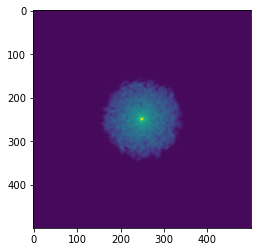

In [20]:
import matplotlib.pyplot as plt 
import numpy as np
plt.imshow(np.log10(dens[:,:,250]))

# how bout a dask array. 


In [21]:
%%time
dens = tag.to_dask(('enzo','Density'), chunks=(50,50,50))

CPU times: user 278 ms, sys: 0 ns, total: 278 ms
Wall time: 277 ms


In [22]:
dens

dask.array<setitem, shape=(500, 500, 500), dtype=float64, chunksize=(50, 50, 50), chunktype=numpy.ndarray>

In [23]:
%%time
vals = dens.compute()

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████| 173/173 [00:00<00:00, 24720.29it/s]

Parsing Hierarchy :   0%|                                                                   | 0/173 [00:00<?, ?it/s]

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████| 173/173 [00:00<00:00, 22388.60it/s]


CPU times: user 22.8 s, sys: 3.54 s, total: 26.3 s
Wall time: 23.1 s


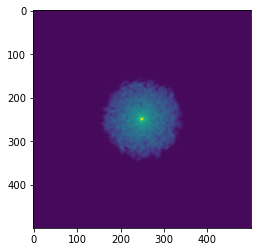

In [24]:
plt.imshow(np.log10(vals[:,:,250]))

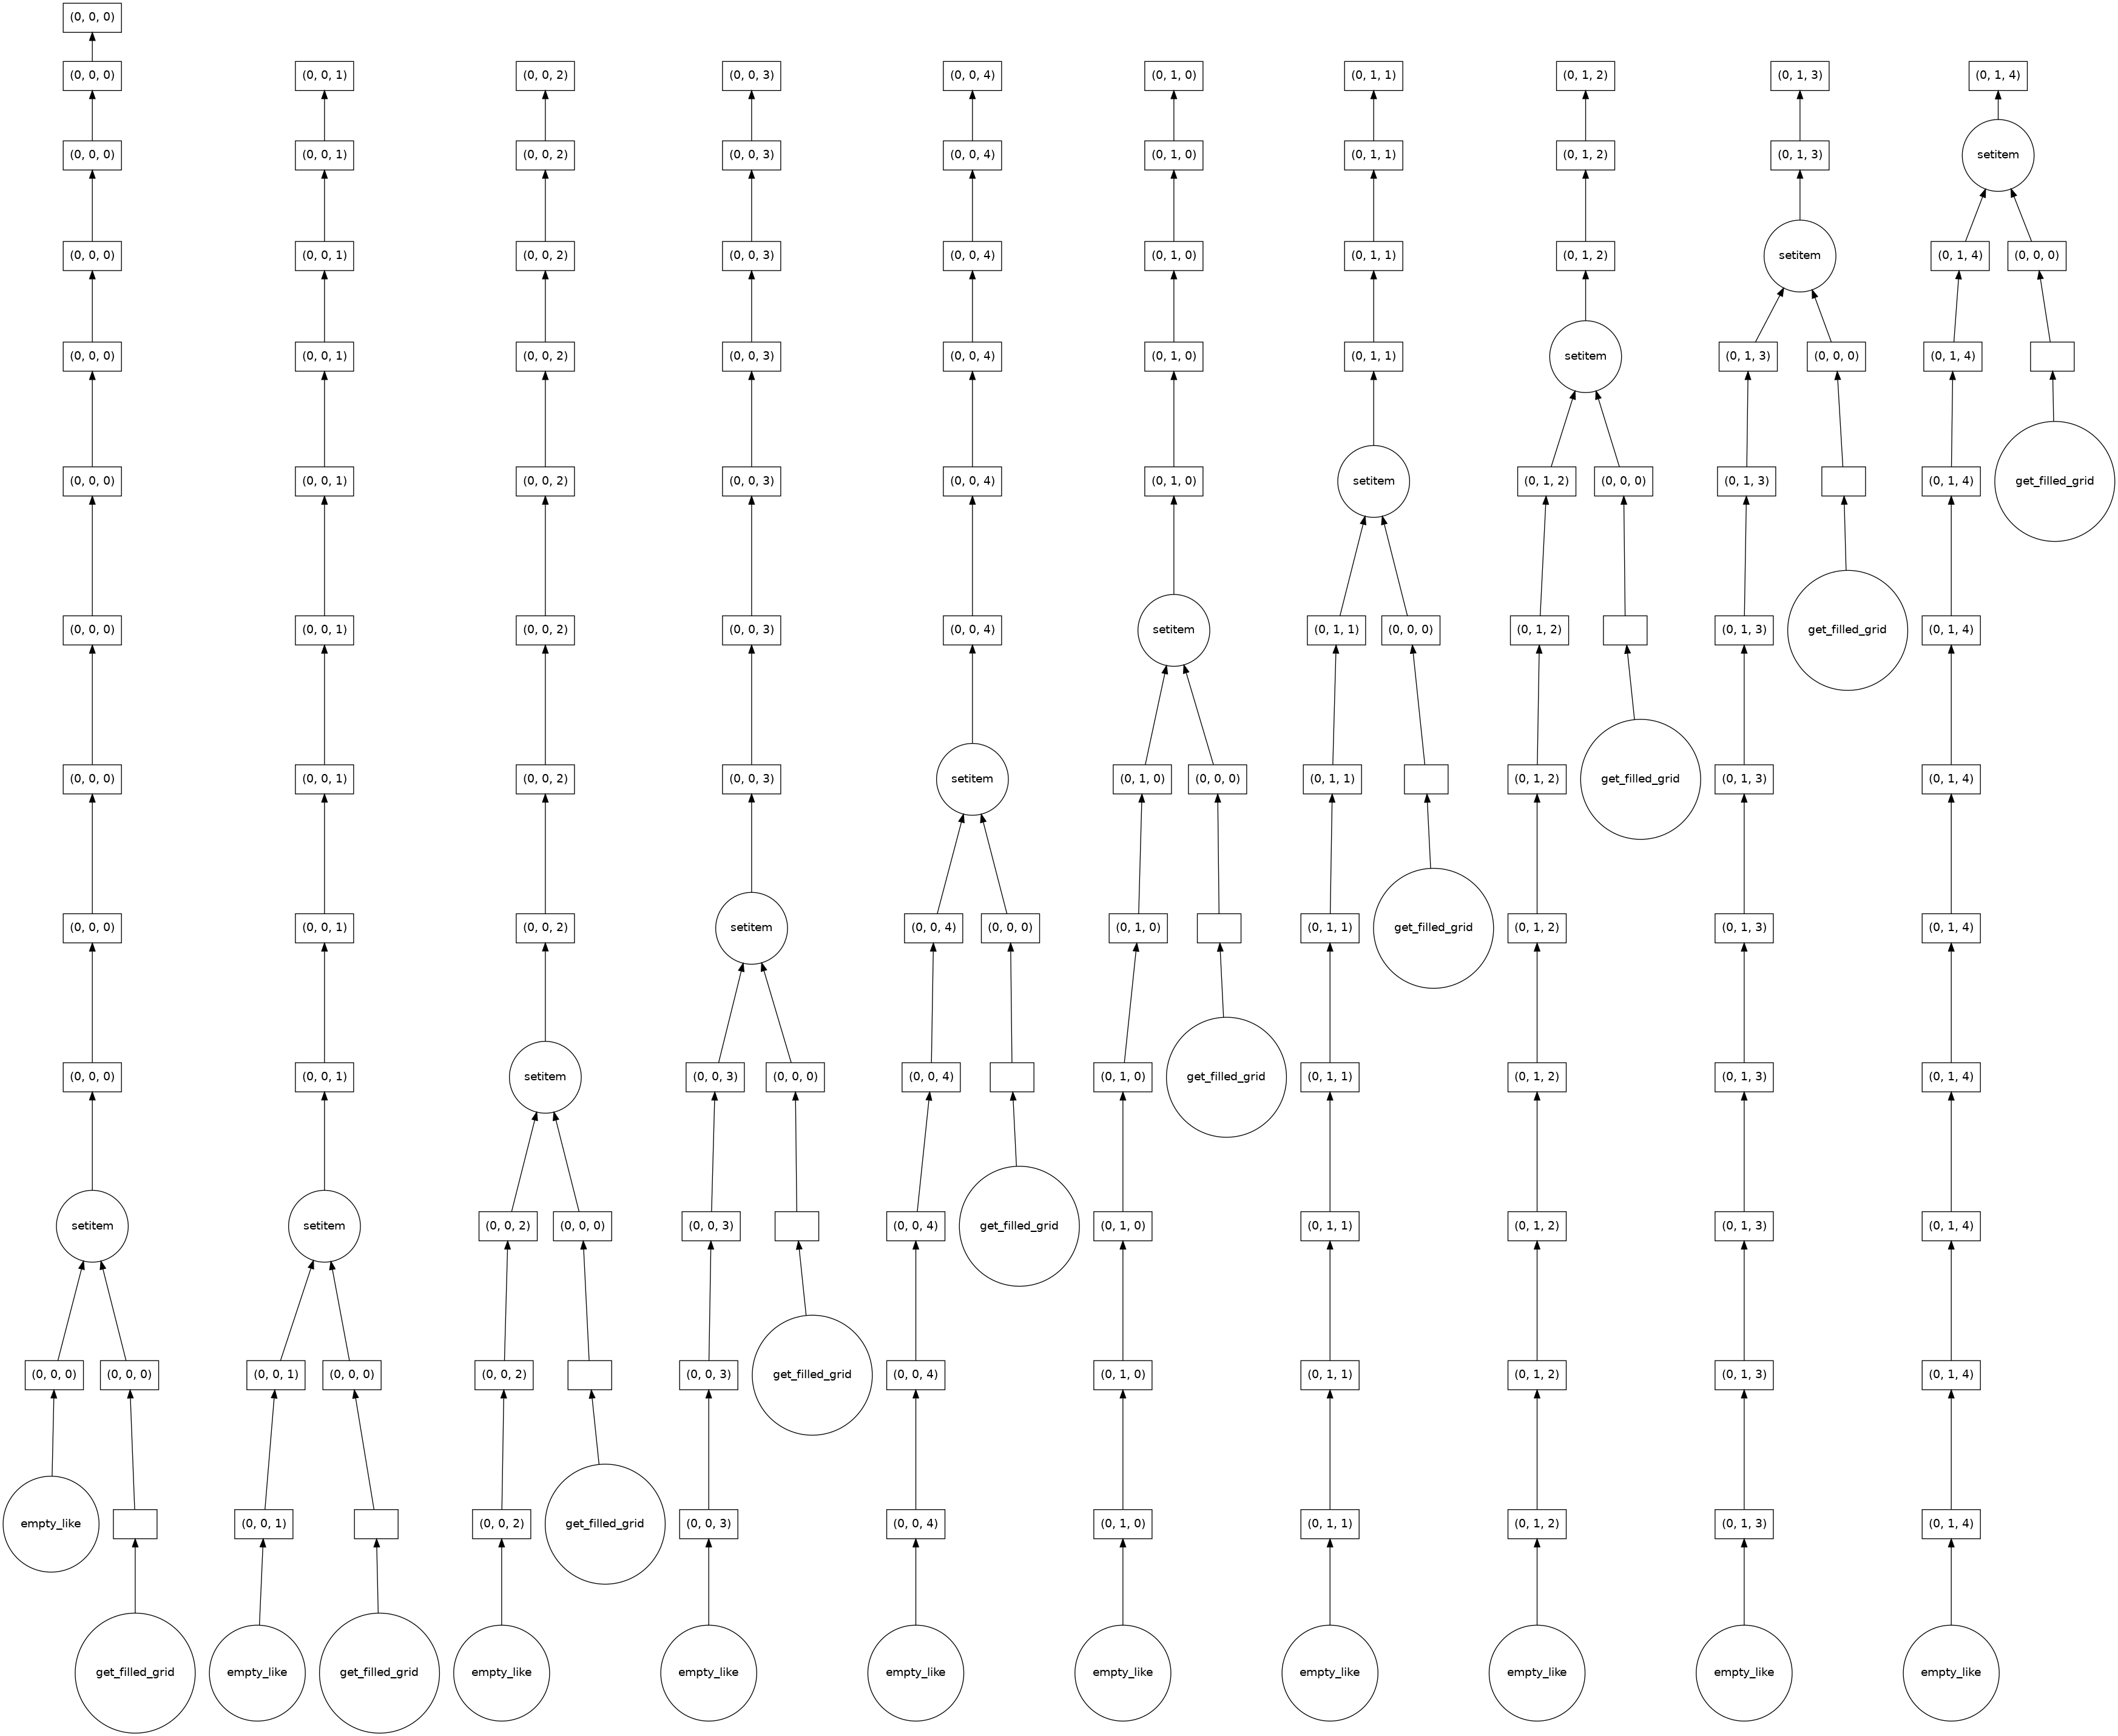

In [26]:
tag.to_dask(('enzo','Density')).visualize()

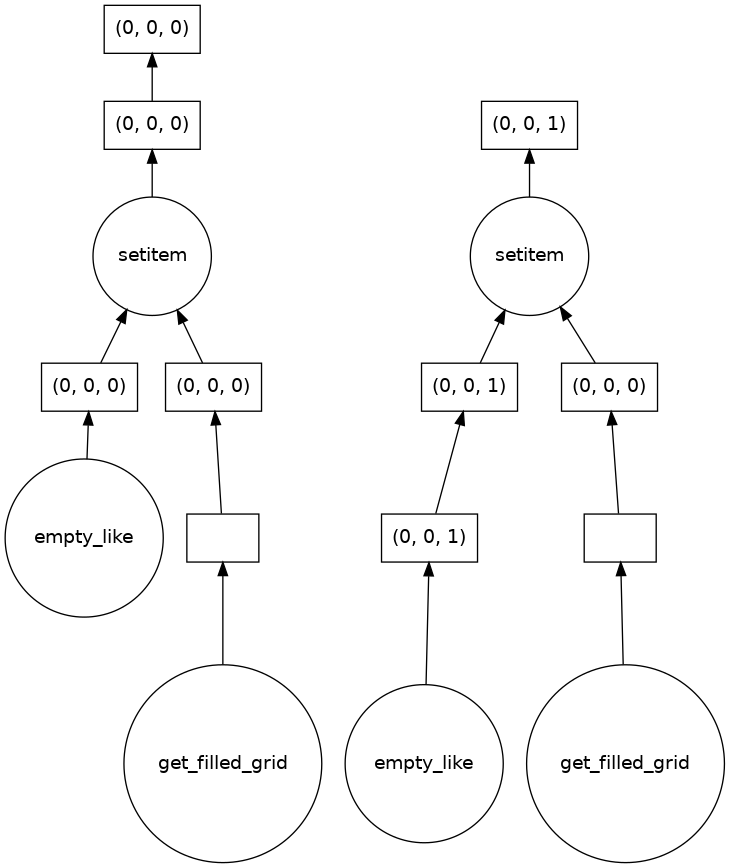

In [27]:
tag_2_grids = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (500,500,500),
                     2,
                     ds=ds)
tag_2_grids.to_dask(('enzo','Density')).visualize()

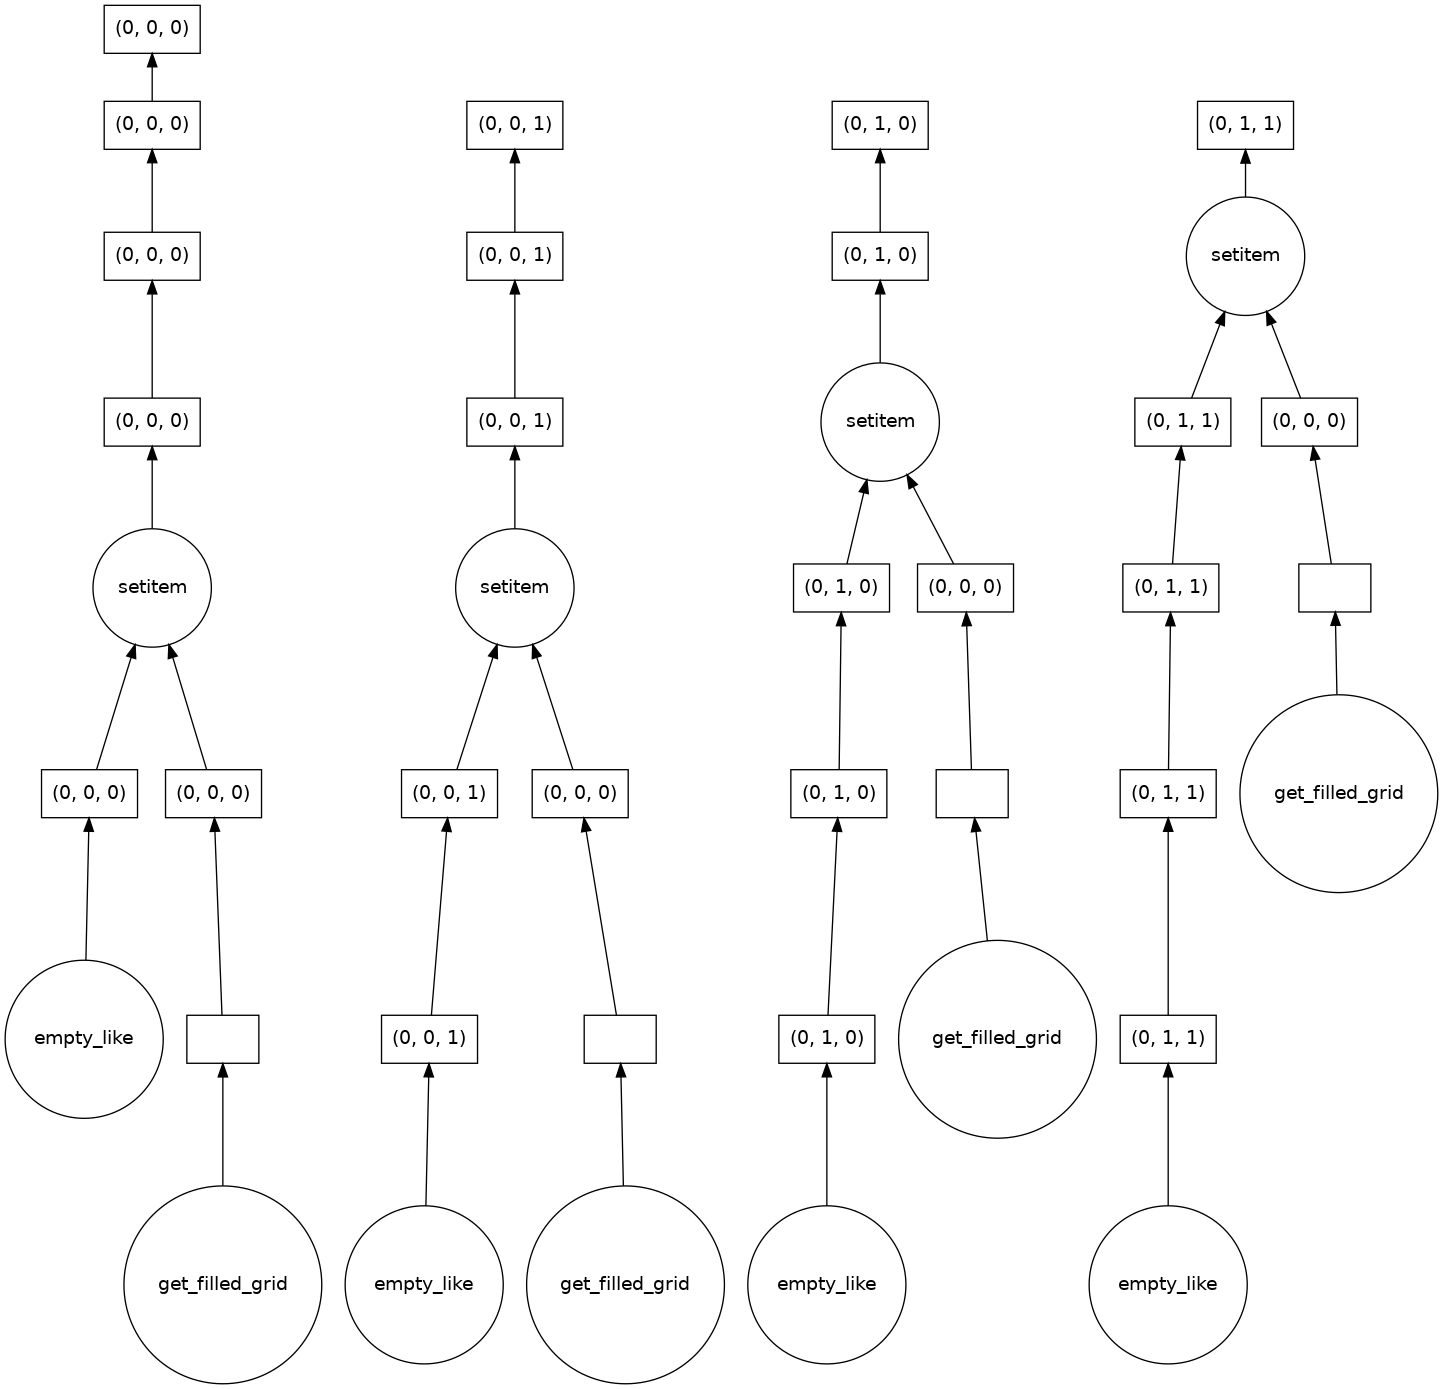

In [28]:
tag_2_grids = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (500,500,500),
                     4,
                     ds=ds)
tag_2_grids.to_dask(('enzo','Density')).visualize()

# and xarray dataaray (backed by dask)

In [34]:
%%time
xr_da = tag.to_xarray(('enzo','Density'))

CPU times: user 7.78 ms, sys: 0 ns, total: 7.78 ms
Wall time: 7.61 ms


In [35]:
xr_ds = xr_da.to_dataset(promote_attrs=True)

In [36]:
xr_ds

<xarray.Dataset>
Dimensions:       (x: 500, y: 500, z: 500)
Coordinates:
  * x             (x) float64 0.001 0.003 0.005 0.007 ... 0.995 0.997 0.999
  * y             (y) float64 0.001 0.003 0.005 0.007 ... 0.995 0.997 0.999
  * z             (z) float64 0.001 0.003 0.005 0.007 ... 0.995 0.997 0.999
Data variables:
    enzo_Density  (x, y, z) float64 dask.array<chunksize=(500, 250, 100), meta=np.ndarray>
Attributes:
    ngrids:     10
    fieldname:  ('enzo', 'Density')

In [37]:
xr_ds.enzo_Density

<xarray.DataArray 'enzo_Density' (x: 500, y: 500, z: 500)>
dask.array<setitem, shape=(500, 500, 500), dtype=float64, chunksize=(500, 250, 100), chunktype=numpy.ndarray>
Coordinates:
  * x        (x) float64 0.001 0.003 0.005 0.007 ... 0.993 0.995 0.997 0.999
  * y        (y) float64 0.001 0.003 0.005 0.007 ... 0.993 0.995 0.997 0.999
  * z        (z) float64 0.001 0.003 0.005 0.007 ... 0.993 0.995 0.997 0.999
Attributes:
    ngrids:     10
    fieldname:  ('enzo', 'Density')

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████| 173/173 [00:00<00:00, 12753.13it/s]


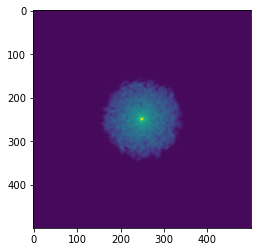

In [38]:
plt.imshow(np.log10(xr_ds.enzo_Density[:,:,250].compute()))

# ok, how bout a bigger array

In [39]:
import yt 
from yt.data_objects.construction_data_containers import YTTiledArbitraryGrid
import matplotlib.pyplot as plt 
import numpy as np

ds = yt.load_sample("IsolatedGalaxy")
tag = YTTiledArbitraryGrid(ds.domain_left_edge,
                     ds.domain_right_edge,
                     (1000,1000,1000),
                     32,
                     ds=ds)

In [40]:
ds.index # INTERESTING: NEED TO BUILD INDEX BEFORE DASK CALL OR YOU GET ERROR

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████| 173/173 [00:00<00:00, 20961.83it/s]


In [ ]:
%%time
da = tag.to_dask(('enzo','Density'), chunks=(100,100,100))
plt.imshow(np.log10(da[:,:,500].compute()))

Parsing Hierarchy :   0%|                                                                   | 0/173 [00:00<?, ?it/s]

Parsing Hierarchy : 100%|███████████████████████████████████████████████████████| 173/173 [00:00<00:00, 7119.87it/s]


scaling seems broken though... bigger arrays fail for some reason. even just buildnig the graph is sloooooow